In [7]:
import numpy as np
from utils import pca, reconstruction, normalized
import os
import cv2 as cv
import math
import random
import pandas as pd
from scipy.spatial import distance

## Preprocessing

In [8]:
dataset_dir = './dataset'
test_ratio = 0.2

In [9]:
# each key in these dicts maps to a class ndarray.
# a class ndarray holds all images for a specefic class.
train_dict, test_dict = (dict(), dict())

# we are considering each folder name as a class label
for class_label in os.listdir(dataset_dir):
  # ignore irrelevant folders.
  # (we only consider folders named like: 'xx' where x is a digit).
  if(len([x for x in class_label if x.isdigit()]) != 2):
    continue

  images = list()
  for i, img_name in enumerate(os.listdir(os.path.join(dataset_dir, class_label))):
    img_path = os.path.join(dataset_dir, class_label, img_name)

    # the next 2 lines convert the image to grayscale
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    # _, b_image = cv.threshold(image, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    b_image = image
    
    # add the image
    images.append(b_image)
  
  # split to train and test according to the set test_ratio. Then convert to numpy ndarrays
  n_test_samples = math.floor(test_ratio * len(images))
  random.shuffle(images)
  test_dict[class_label] = np.array(images[:n_test_samples], dtype=np.float64)
  train_dict[class_label] = np.array(images[n_test_samples:], dtype=np.float64)

## Constructing PCA Matrix

We will construct a PCA matrix for each class and store them in a dictionary. Each key is a class label and maps to the corresponding matrix

In [10]:
n_components = 50

In [11]:
pca_by_class = dict()
for class_label in train_dict:
  images = train_dict[class_label]
  n_samples, h, w = images.shape
  pca_by_class[class_label] = pca(images.reshape(n_samples, h*w), n_components)

# Testing

{'08': 0.9, '06': 1.0, '09': 1.0, '02': 1.0}


<AxesSubplot:title={'center':'Accuracy'}>

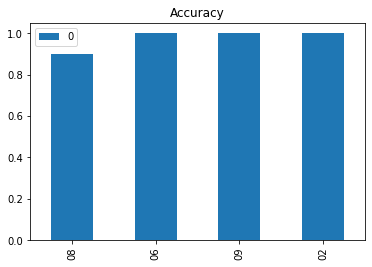

In [12]:
# this dict will hold the accuracy for each class.
accuracy = dict()

for true_class_label in test_dict:
  images = test_dict[true_class_label]
  n_samples, h, w = images.shape
  X = images.reshape(n_samples, h*w)
  
  hits = 0
  for i in range(n_samples):
    distances = []
    class_labels = []
    for class_label in pca_by_class:
      C, M, _ = pca_by_class[class_label]
      recovered_image = reconstruction(X - M, C, M, h, w, i)
      dist = distance.euclidean(normalized(images[i].reshape(h*w)), normalized(recovered_image.reshape(h*w)))

      distances.append(dist)
      class_labels.append(class_label)

    predicted_class_label = class_labels[np.argmin(distances)]
    if(predicted_class_label == true_class_label):
      hits += 1
  accuracy[true_class_label] = hits / n_samples

print(accuracy)
accuracy_df = pd.DataFrame(data=accuracy.values(), index=accuracy.keys())
accuracy_df.plot(title='Accuracy', kind='bar')